In [1]:
from SimPEG import DC, IP
from SimPEG import Maps, Utils
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pylab import hist
from pymatsolver import Pardiso as Solver
plotIt=False
survey_type="dipole-dipole"
    
np.random.seed(1)
# Initiate I/O class for DC
IO = DC.IO()
# Obtain ABMN locations

xmin, xmax = 0., 200.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0
endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
# Generate DC survey object
survey_dc = DC.Utils.gen_DCIPsurvey(endl, survey_type=survey_type, dim=2,
                                 a=10, b=10, n=10)
survey_dc.getABMN_locations()
survey_dc = IO.from_ambn_locations_to_survey(
    survey_dc.a_locations, survey_dc.b_locations,
    survey_dc.m_locations, survey_dc.n_locations,
    survey_type, data_dc_type='volt', data_ip_type='volt'
)

# Obtain 2D TensorMesh
mesh, actind = IO.set_mesh()
topo, mesh1D = DC.Utils.genTopography(mesh, -10, 0, its=100)
actind = Utils.surface2ind_topo(mesh, np.c_[mesh1D.vectorCCx, topo])
survey_dc.drapeTopo(mesh, actind, option="top")

# Build conductivity and chargeability model
blk_inds_c = Utils.ModelBuilder.getIndicesSphere(
    np.r_[60., -25.], 12.5, mesh.gridCC
)
blk_inds_r = Utils.ModelBuilder.getIndicesSphere(
    np.r_[140., -25.], 12.5, mesh.gridCC
)
blk_inds_charg = Utils.ModelBuilder.getIndicesSphere(
    np.r_[100., -25], 12.5, mesh.gridCC
)
sigma = np.ones(mesh.nC)*1./100.
sigma[blk_inds_c] = 1./10.
sigma[blk_inds_r] = 1./1000.
sigma[~actind] = 1./1e8
rho = 1./sigma
charg = np.zeros(mesh.nC)
charg[blk_inds_charg] = 0.1

Using a seed of:  37


/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:232: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"
/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:504: UserWarning: dx is set to 2.5 m (samllest electrode spacing (10.0) / 4)
  "dx is set to {} m (samllest electrode spacing ({}) / {})".format(dx, a, ncell_per_dipole)
/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:509: UserWarning: dz (1.25 m) is set to dx (2.5 m) / 2
  "dz ({} m) is set to dx ({} m) / {}".format(dz, dx, 2)


In [2]:
actmap = Maps.InjectActiveCells(
    mesh, indActive=actind, valInactive=np.log(1e8)
)
mapping = Maps.ExpMap(mesh) * actmap
prb = DC.Problem2D_N(
        mesh, rhoMap=mapping, storeJ=True,
        Solver=Solver
)
prb.pair(survey_dc)

In [3]:
dc_voltage = survey_dc.dpred(np.log(1./sigma[actind]))

In [4]:
actmap = Maps.InjectActiveCells(
    mesh, indActive=actind, valInactive=0.
)
prb_ip = IP.Problem2D_N(
    mesh, etaMap=actmap, storeJ=True, rho=1./sigma,
    Solver=Solver,
    verbose=True
)
survey_ip = IP.from_dc_to_ip_survey(survey_dc, dim="2.5D")
prb_ip.pair(survey_ip)
dc_data = prb_ip.set_dc_data(dc_voltage)
dtrue_ip = survey_ip.makeSyntheticData(charg[actind], std=0.05)

>> Compute DC fields
Calculating J and storing
SimPEG.Survey assigned new std of 5.00%


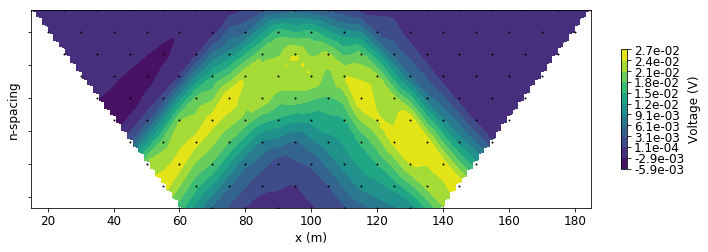

In [5]:
IO.plotPseudoSection(data=dtrue_ip, data_type='volt', scale='linear')

(array([ 2.,  3.,  6.,  7.,  6., 12., 22., 11., 19., 47.]),
 array([-5.21750931, -4.85177696, -4.48604461, -4.12031227, -3.75457992,
        -3.38884757, -3.02311522, -2.65738287, -2.29165052, -1.92591817,
        -1.56018582]),
 <a list of 10 Patch objects>)

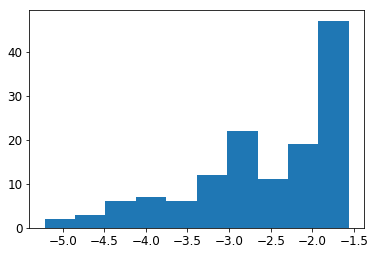

In [6]:
hist(np.log10(abs(survey_ip.dobs)))

In [7]:
std_ip, eps_ip = 0.05, 1e-3
m0_ip = np.ones(actmap.nP)*1e-10
mopt_ip, pred_ip = IP.run_inversion(
    m0_ip, survey_ip, actind, mesh, std_ip, eps_ip,
    upper=np.Inf, lower=0.,
    beta0_ratio=1.,
    use_sensitivity_weight=False,
    alpha_s=0.01
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
>> Compute DC fields
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
>> Compute DC fields
   0  3.19e+03  2.83e+03  0.00e+00  2.83e+03    1.23e+04      0              
>> Compute DC fields
   1  3.19e+03  5.24e+02  1.75e-02  5.80e+02    3.22e+03      0              
>> Compute DC fields
   2  6.38e+02  2.40e+02  4.17e-02  2.67e+02    2.66e+03      0   Skip BFGS  
>> Compute DC fields
   3  6.38e+02  1.18e+02  6.21e-02  1.57e+02    2.08e+03      0   Skip BFGS  
>> Compute DC fields
   4  1.28e+02  7.67e+0

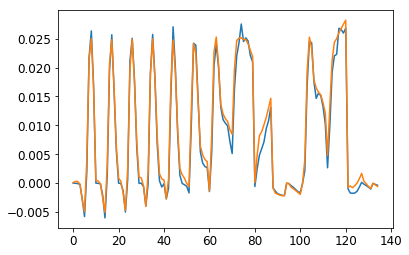

In [8]:
plt.plot(survey_ip.dobs)
plt.plot(pred_ip)

(<matplotlib.collections.QuadMesh at 0xd2807fcc0>,)

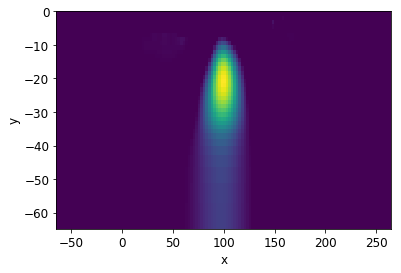

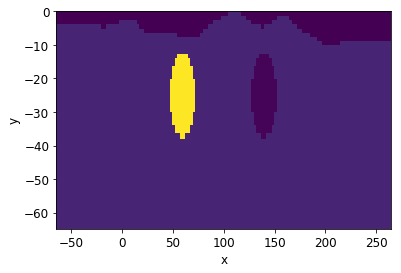

In [9]:
mesh.plotImage(actmap*mopt_ip)
mesh.plotImage(sigma)